In [51]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import csv

import rn_loader

In [52]:
# hyperparams
epochs = 10
ngf = 128            # render net feature map size
batch_size = 128

criterion = nn.BCELoss()


# optimizer hyperparams
lr = 0.0002          # learning rate
beta1 = 0.5
optimizer = optim.Adam(rnet.parameters(), lr=lr, betas=(beta1, 0.999))

# global vars
dataroot = "data/"   # root directory for training data
image_size = 128     # training image size
workers = 0          # number of dataloader workers
ngpu = 1             # number of gpus to use
nc = 3               # number of color channels in the input image





In [53]:
# load dataset
rnet_dataset = rn_loader.RenderNetDataset(csv_file='data/labels.csv',
                                          root_dir='data/judkins_box',
                                          transform=transforms.Compose([
                                              transforms.ToPILImage(),
                                              transforms.Resize(image_size),
                                              transforms.CenterCrop(image_size),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                          ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(rnet_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [54]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Using device ", device)

Using device  cuda:0


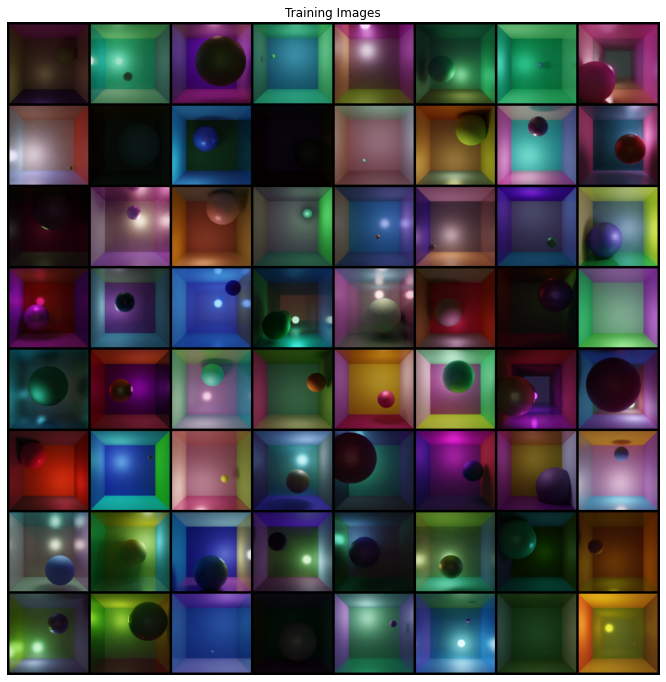

tensor([ 5.9912e-01,  4.2280e-01,  3.0924e-01,  5.8940e-01,  4.5401e-01,
         8.2257e-01,  4.3094e-01,  4.6334e-01,  2.8927e-01,  1.4835e-01,
         9.7570e-01,  9.2191e-01,  3.9469e-01,  8.5253e-01,  9.3048e-01,
         1.6345e-01,  5.3246e-02,  5.9730e-01,  7.7723e-01,  5.1246e-01,
         9.8504e-01,  1.3375e-01,  8.5012e-01,  2.2227e-01,  7.2861e-01,
         9.0529e-01,  8.5336e-01,  3.0904e-01,  9.0540e-01,  9.6567e-01,
         9.1944e-01,  5.2884e-01, -9.4546e-01, -2.3339e+02, -1.7452e+02,
         1.9245e+02,  4.9692e-01, -3.0670e-01, -7.9361e-01,  6.8797e-01,
         4.6694e-01,  4.9216e-01,  2.7755e-01,  9.1171e+00])


In [55]:
# Plot some training images
data_iter = iter(dataloader)

data = data_iter.next()

plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(data['image'].to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))
plt.show()

print(data['scene'][0])
scene_size = len(data['scene'][0])

In [56]:
# RenderNet

class RenderNet(nn.Module):
    def __init__(self, ngpu):
        super(RenderNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(scene_size, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            nn.ReLU(True)
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [57]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [58]:
# Create the render network
rnet = RenderNet(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    rnet = nn.DataParallel(rnet, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
rnet.apply(weights_init)

# Print the model
print(rnet)

RenderNet(
  (main): Sequential(
    (0): ConvTranspose2d(44, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Bat

tensor([ 1.6116e-01,  9.6797e-01,  8.2825e-01,  9.3062e-03,  3.7759e-02,
         4.7116e-01,  3.9790e-01,  6.6458e-01,  7.4602e-01,  6.6065e-01,
         4.5789e-03,  4.3796e-01,  7.4381e-01,  2.3755e-01,  1.0142e-01,
         8.8056e-01,  8.5618e-01,  8.0991e-01,  3.1534e-01,  7.9008e-01,
         4.5534e-01,  8.1499e-01,  3.7283e-01,  5.6793e-02,  3.4896e-01,
         9.1606e-01,  8.2466e-01,  7.8796e-01,  8.2041e-01,  8.0722e-01,
        -1.0005e-01, -5.2831e-01,  4.2411e-01,  1.3570e+02,  5.8512e+01,
        -2.5967e+02,  1.9802e-01, -7.0949e-01,  1.7163e-01, -9.9528e-01,
         4.9627e-01,  7.2756e-01,  3.4696e-01,  2.4063e+01], device='cuda:0')


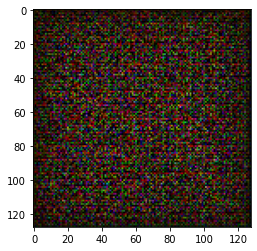

tensor([ 3.2912e-01,  4.2088e-02,  8.1374e-01,  6.3542e-01,  6.1744e-01,
         9.0235e-01,  7.2161e-01,  5.0603e-01,  4.4784e-01,  2.5636e-01,
         2.1120e-01,  4.9670e-01,  2.7198e-01,  1.5740e-01,  3.6379e-01,
         9.9930e-01,  2.6471e-01,  4.5871e-01,  4.9915e-01,  7.7130e-01,
         7.9056e-01,  7.8543e-01,  1.7630e-01,  8.1559e-01,  3.2678e-01,
         2.5980e-01,  4.8655e-01,  1.3801e-01,  5.7452e-01,  4.3990e-01,
         3.1887e-01,  9.7194e-02,  9.8112e-01, -2.6116e+02,  7.4388e+01,
         3.4129e+01,  9.1189e-01,  1.1566e-01,  7.2092e-01,  5.0849e-02,
         3.3561e-01,  7.9986e-02,  6.7340e-01,  6.2258e+01], device='cuda:0')


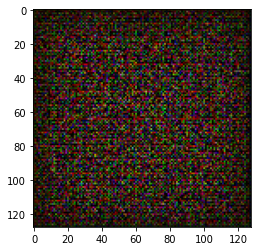

In [59]:
# show some output images with no training, just to make sure the network is connected
for i in range(1,3):
    scene_vec = torch.FloatTensor(data['scene'][i]).to('cuda')#torch.FloatTensor([float(ele) for ele in labels[i]]).to('cuda')
    nn_input = scene_vec.view(1, scene_size, 1, 1)

    fake = rnet(nn_input).detach().cpu()
    img = np.transpose(torch.squeeze(fake), (1,2,0))

    plt.imshow(img)
    plt.imsave('untrained.png', arr=img.numpy())
    print(scene_vec)
    plt.show()

Epoch #0


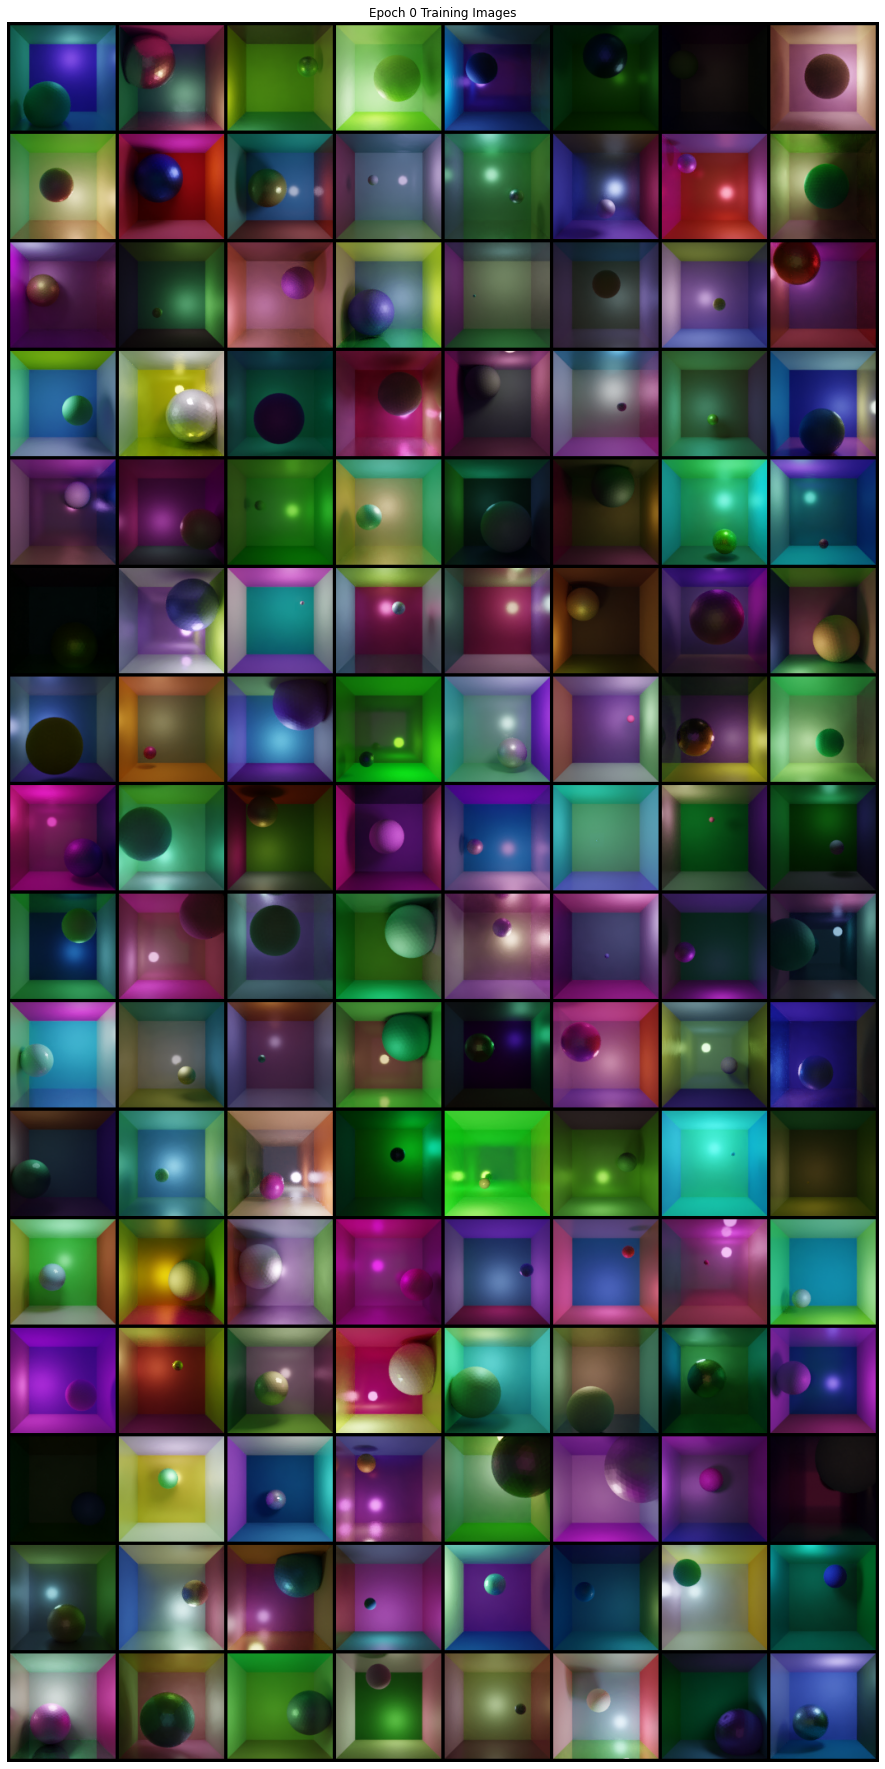

<class 'torch.Tensor'>


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 3, 128, 128]], which is output 0 of TanhBackward, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [60]:
# training loop
for e in range(epochs):
    print("Epoch #%d" % e)
    # For each batch in the dataloader
    data_iter = iter(dataloader)
    data = data_iter.next()

    plt.figure(figsize=(32,32))
    plt.axis("off")
    plt.title("Epoch %d Training Images" % e)
    plt.imshow(np.transpose(vutils.make_grid(data['image'].to(device)[:batch_size], padding=4, normalize=True).cpu(),(1,2,0)))
    plt.show()

    rnet.zero_grad()
    for idx in range(batch_size):
        scene = data['scene'][idx]
        image = data['image'][idx].to(device=device)
        #image.requires_grad = False

        #print(scene)
        output = rnet(scene.view(1, 44, 1, 1).to(device=device))
        #plt.imshow(np.transpose(torch.squeeze(output.detach().cpu()), (1,2,0)))
        #plt.show()

        with torch.autograd.detect_anomaly():
            loss = criterion(output, image.unsqueeze(0))
            print(loss.device)
            print(loss.requires_grad)
            loss.backward()
            print(loss)
            optimizer.step()


In [ ]:
foo = torch.randn(2, 4, 1, 1)
print(foo)